<a href="https://colab.research.google.com/github/Srs-satya/Air-Quality-Prediction/blob/main/Air_Quality_Prediction_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install prophet

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from prophet import Prophet

In [10]:
df = pd.read_csv('/air_pollution_data.csv')

In [11]:
df.head()

,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,Ahmedabad,03-12-2020,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,Ahmedabad,04-12-2020,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53


In [12]:
df.isnull().sum()

,0
city,0
date,0
aqi,0
co,0
no,0
no2,0
o3,0
so2,0
pm2_5,0
pm10,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     23504 non-null  float64
 6   o3      23504 non-null  float64
 7   so2     23504 non-null  float64
 8   pm2_5   23504 non-null  float64
 9   pm10    23504 non-null  float64
 10  nh3     23504 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [14]:
df.describe()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,23504.000000,23504.000000,23504.00000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000
mean,3.920354,1113.224543,6.00554,25.044104,35.059777,15.971449,98.598310,121.848091,12.060212
std,1.415490,1401.770372,24.50272,25.839242,31.901760,23.943464,135.572391,160.429589,17.544759
min,1.000000,173.570000,0.00000,0.310000,0.000000,0.190000,0.500000,0.580000,0.000000
25%,3.000000,447.270000,0.00000,8.740000,7.870000,4.470000,24.677500,32.277500,2.340000
50%,5.000000,700.950000,0.00000,16.450000,28.250000,7.990000,58.860000,75.775000,6.520000
75%,5.000000,1188.280000,0.27000,32.220000,54.360000,16.450000,117.605000,147.642500,15.830000
max,5.000000,23071.290000,457.76000,331.760000,406.270000,442.510000,2203.550000,2429.130000,352.620000


In [33]:
df.replace(-200, np.nan, inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)
df = df.sort_values('Datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   city      23504 non-null  object        
 1   aqi       23504 non-null  int64         
 2   co        23504 non-null  float64       
 3   no        23504 non-null  float64       
 4   no2       23504 non-null  float64       
 5   o3        23504 non-null  float64       
 6   so2       23504 non-null  float64       
 7   pm2_5     23504 non-null  float64       
 8   pm10      23504 non-null  float64       
 9   nh3       23504 non-null  float64       
 10  Datetime  23504 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 2.2+ MB


In [35]:
# Keep only pollutant features and Datetime
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
df = df[['Datetime'] + features]

# Scale the data
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

/tmp/ipython-input-35-557117370.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler.fit_transform(df[features])


In [37]:
# Prepare data for Prophet
prophet_df = df[['Datetime', 'co']].rename(columns={"Datetime": "ds", "co": "y"})

# Train-test split: Use 80% for training
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size]
test = prophet_df[train_size:]

# Fit model
model = Prophet()
model.fit(train)

# Predict on the test set
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

# Merge predictions with test
forecast = forecast[['ds', 'yhat']].set_index('ds')
test = test.set_index('ds')
merged = test.join(forecast, how='left')

# Evaluate
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
r2 = r2_score(merged['y'], merged['yhat'])

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8wg6d6d2/wkwb7htx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8wg6d6d2/qgmijx8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24396', 'data', 'file=/tmp/tmp8wg6d6d2/wkwb7htx.json', 'init=/tmp/tmp8wg6d6d2/qgmijx8i.json', 'output', 'file=/tmp/tmp8wg6d6d2/prophet_modelru32xl0k/prophet_model-20250720144241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

MAE: 1.1494, RMSE: 1.4025, R²: -0.7251


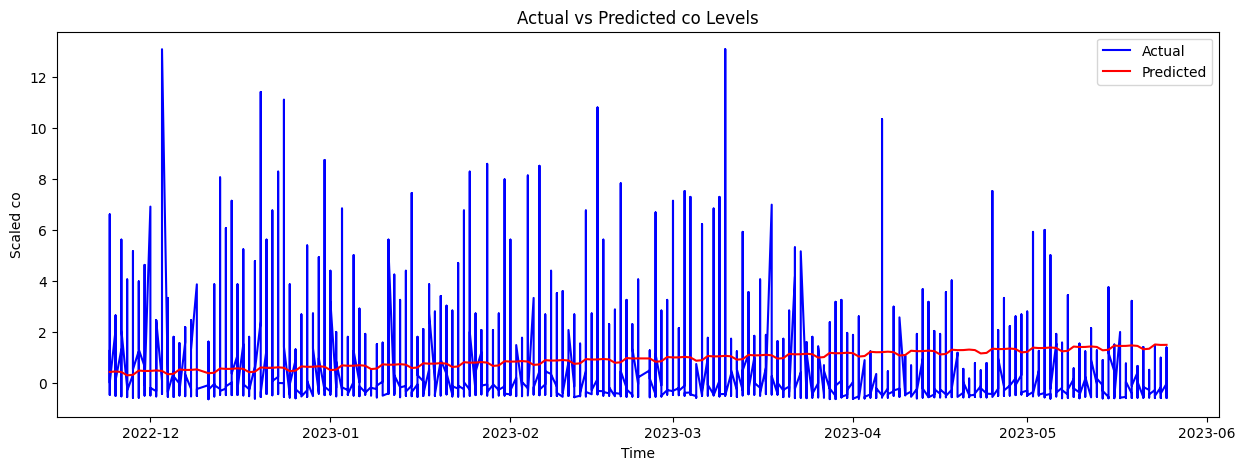

In [38]:
# Actual vs Predicted
plt.figure(figsize=(15, 5))
plt.plot(merged['y'], label='Actual', color='blue')
plt.plot(merged['yhat'], label='Predicted', color='red')
plt.title('Actual vs Predicted co Levels')
plt.xlabel('Time')
plt.ylabel('Scaled co')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


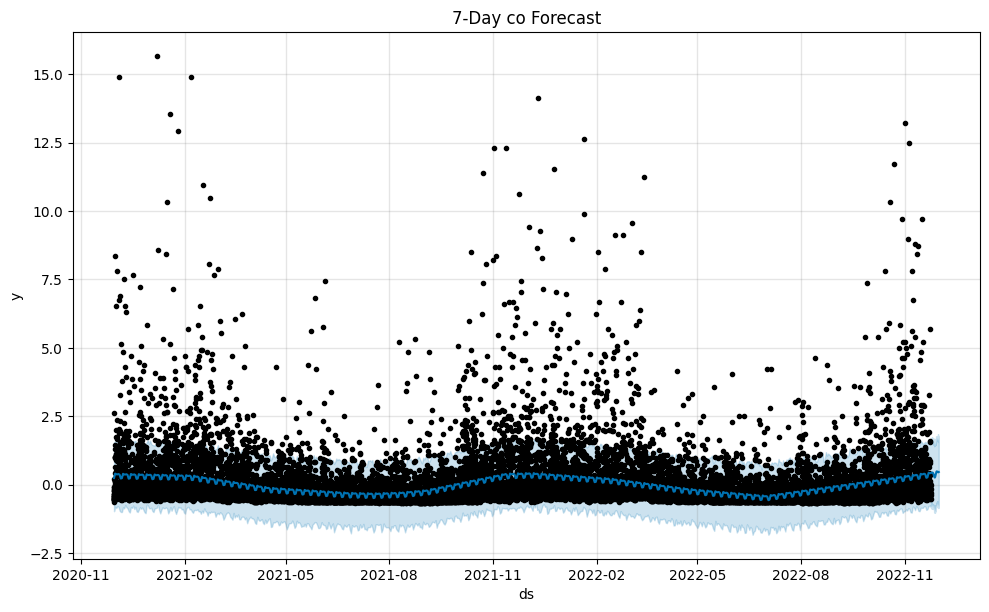

In [39]:
# Predict next 7 days hourly
future_week = model.make_future_dataframe(periods=24*7, freq='H')
forecast_week = model.predict(future_week)

# Plot future prediction
model.plot(forecast_week)
plt.title("7-Day co Forecast")
plt.show()
